In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.dpgpd import Dpgpd
from src.sampling import Sampler

In [4]:
from typing import Tuple
import numpy as np
import torch
from torch import Tensor

from src.config import Config


class RobotWorld:
    def __init__(self) -> None:
        self.s_r = torch.tensor(Config.s_r)
        self.rng = np.random.default_rng()
        self.A, self.B = self.generate_dynamics(Config.time_step)
        self.boundaries = torch.tensor(
            [
                Config.x_range,
                Config.y_range,
                Config.vx_range,
                Config.vy_range,
            ]
        ).double()

    def generate_initial_point(self, x_range, y_range, vx_range, vy_range) -> np.ndarray:
        s_0 = torch.tensor([
            self.rng.uniform(*x_range),
            self.rng.uniform(*y_range),
            self.rng.uniform(*vx_range),
            self.rng.uniform(*vy_range),
        ]).double()
        return (s_0 - self.s_r)

    def generate_dynamics(self, dt: float) -> Tuple[np.ndarray, np.ndarray]:
        A = torch.tensor(
            [
                [1., 0, dt, 0],
                [0, 1., 0, dt],
                [0, 0, 1., 0],
                [0, 0, 0, 1.],
            ]
        ).double()

        B = torch.tensor(
            [
                [dt**2 / 2, 0.0],
                [0.0, dt**2 / 2],
                [dt, 0.0],
                [0.0, dt],
            ]
        ).double()

        return A, B

    def reset(self):
        self.s = self.generate_initial_point(
            [-10, 10],
            [-10, 10],
            Config.vx_range,
            Config.vy_range
        )
        return self.s

    def generate_noise(self, size: int) -> Tensor:
        return torch.tensor(
            self.rng.normal(
            scale=np.array(
                [
                    Config.noise_pos,
                    Config.noise_pos,
                    Config.noise_vel,
                    Config.noise_vel
                ]
            ) * Config.time_step,
            size=size,
        )
        )

    def step(self, u: np.ndarray) -> np.ndarray:
        noise = self.generate_noise(self.s.shape[0])
        self.s_noiseless = self.s @ self.A.T + u @ self.B.T 
        self.s = self.s_noiseless + noise
        #self.s = torch.clip(self.s, self.boundaries[:, 0], self.boundaries[:, 1])
        return self.s


In [5]:
env = RobotWorld()
s = env.reset()
(torch.sqrt(s[0]**2 + s[1]**2) < 10) * 1.0 - 1.0

tensor(0.)

In [6]:
from typing import List, Tuple
from numpy.random import default_rng
from torch import (
    eye, inverse, zeros, clamp, concat, cartesian_prod, tensor, ger, flatten, diag, Tensor
)
from torch.linalg import lstsq

#from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.sampling import Sampler


RNG_SAMPLING = [-10, 10]


class ADpgpdSampledVariance:
    def __init__(
            self,
            env: RobotWorld,
            eta: float,
            tau: float,
            gamma: float,
            b: float,
            alpha: float,
            G: Tensor,
            R: Tensor,
        ) -> None:
        self.env = env
        self.eta = eta
        self.tau = tau
        self.gamma = gamma
        self.b = b
        self.alpha = alpha
        self.ds, self.da = env.B.shape

        self.G = G
        self.R = R

        self.lqr = Lqr(env.A, env.B, gamma)
        self.sampler = Sampler(env, gamma)

    def get_initial_point(self) -> Tuple[Tensor, Tensor]:
        rng = default_rng()

        s = tensor([
            rng.uniform(*[-10, 10]),
            rng.uniform(*[-10, 10]),
            rng.uniform(*RNG_SAMPLING),
            rng.uniform(*RNG_SAMPLING),
        ]).double()

        a = tensor([
            rng.uniform(*RNG_SAMPLING),
            rng.uniform(*RNG_SAMPLING),
        ]).double()

        return s, a

    def primal_reward(self, a):
        r_pos = - torch.clip(torch.sqrt(env.s[0]**2 + env.s[1]**2) - 5, min=0)**2
        r_a = a @ self.R @ a
        return (r_pos + r_a).detach().item()

    def dual_reward(self):
        return - torch.clip(torch.sqrt(env.s[0]**2 + env.s[1]**2) - 1, max=0)**2

    def rollout_Q(self, s: Tensor, a: Tensor, K: Tensor, n: int, lmbda) -> float:
        self.env.s = s
        self.env.s_noiseless = s
        q = self.primal_reward(a) + lmbda * self.dual_reward()
        s = self.env.step(a)
        for i in range(1, n):
            a = s @ K.T
            r = self.primal_reward(a) + lmbda * self.dual_reward()
            q += (self.gamma ** i) * r
            s = self.env.step(a)
        return q

    def rollout_V_rho(self, K, n_samples, n_rollout, is_primal):
        s = torch.tensor([
            self.env.rng.uniform(-10, 10, n_samples),
            self.env.rng.uniform(-10, 10, n_samples),
            self.env.rng.uniform(-0.1, 0.1, n_samples),
            self.env.rng.uniform(-0.1, 0.1, n_samples),
        ]).double().T

        v = 0
        for i in range(n_rollout):
            a = s @ K.T
            noise = self.env.generate_noise([n_samples, 4])
            sp = s @ self.env.A.T + a @ self.env.B.T + noise

            r_primal = - torch.clip(torch.sqrt(s[:, 0]**2 + s[:, 1]**2) - 5, min=0)**2 + ((a @ self.R) * a).sum(dim=1)
            r_dual = - torch.clip(torch.sqrt(s[:, 0]**2 + s[:, 1]**2) - 1, max=0)**2
            r = is_primal * r_primal + (1 - is_primal) * r_dual
            v += (self.gamma ** i) * r

            s = sp
        return v.mean().detach().item()

    def policy_evaluation(self, K: Tensor, lmbda: Tensor, n_samples: int, n_rollout: int) -> Tensor:
        X, y = zeros((n_samples, 36)), zeros(n_samples)
        for n in range(n_samples):
            s, a = self.get_initial_point()
            s_a = concat([s, a])
            b = flatten(ger(s_a, s_a) + diag((self.alpha - 1) * s_a**2))

            a_pi = s @ K.T
            q = self.rollout_Q(s, a, K, n_rollout, lmbda)
            l = q + (1 / self.eta) * a_pi @ a

            X[n] = b
            y[n] = l
        theta = lstsq(X, y, driver='gelsd').solution
        return theta

    def primal_update(self, theta: Tensor) -> Tensor:
        W_1 = zeros((self.da, self.ds))
        for i in range(self.da):
            for j in range(self.ds):
                s_idx, a_idx = zeros(self.ds), zeros(self.da)
                s_idx[j] = -1
                a_idx[i] = 1
                s_a_idx = concat([s_idx, a_idx])
                mask = - cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_1[i, j] = w

        W_2 = zeros((self.da, self.da))
        for i in range(self.da):
            for j in range(self.da):
                s_idx, a_idx = zeros(self.ds), zeros(self.da)
                a_idx[i] = 1
                a_idx[j] = -1
                s_a_idx = concat([s_idx, a_idx])

                if i == j:
                    mask = cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                    w = (theta * mask).sum()
                    W_2[i, j] = 2 * w * self.alpha
                else:
                    mask = - cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                    w = (theta * mask).sum()
                    W_2[i, j] = w
        K = - inverse(W_2 - (self.tau + 1 / self.eta) * eye(self.da)) @ W_1
        return K.double()

    def dual_update(self, K: Tensor, lmbda: Tensor, n_samples: int, n_rollout) -> Tensor:
        v = self.rollout_V_rho(K, n_samples, n_rollout, 0)
        return clamp(lmbda - self.eta * (v - self.b + self.tau * lmbda), min=0), v

    def train_unconstrained(self, epochs: int, n_pe: int, n_rho: int, n_roll: int) -> Tuple[Tensor, List[float], List[float]]:
        losses_primal, losses_dual = [], []
        theta = zeros((self.ds + self.da)**2)
        K = self.primal_update(theta)
        for e in range(epochs):
            if e % 10 == 0:
                loss_primal = self.rollout_V_rho(K, n_rho, n_roll, 1)
                loss_dual = self.rollout_V_rho(K, n_rho, n_roll, 0)
                losses_primal.append(loss_primal)
                losses_dual.append(loss_dual)

            theta = self.policy_evaluation(K, 0, n_pe, n_roll)
            K = self.primal_update(theta)

            print(f"Episode {e}/{epochs} - Return {loss_primal} \r", end='')
        return K, losses_primal, losses_dual

    def train_constrained(self, epochs: int, n_pe: int, n_rho: int, n_roll: int) -> Tuple[Tensor, Tensor, List[float], List[float]]:
        losses_primal, losses_dual = [], []
        theta = zeros((self.ds + self.da)**2)
        K = self.primal_update(theta)
        lmbda = zeros(1)
        for e in range(epochs):
            if e % 10 == 0:
                loss_primal = self.rollout_V_rho(K, n_rho, n_roll, 1)
                #loss_dual = self.rollout_V_rho(K, n_rho, n_roll, 0)
                losses_primal.append(loss_primal)
                #losses_dual.append(loss_dual)

            theta = self.policy_evaluation(K, lmbda, n_pe, n_roll)
            K = self.primal_update(theta)
            lmbda, loss_dual = self.dual_update(K, lmbda, n_rho, n_roll)
            losses_dual.append(loss_dual)

            print(f'Episode {e}/{epochs} - Return {loss_primal} - Constrain {loss_dual} - Lambda {lmbda.detach().item()}\r', end='')
        return K, lmbda, losses_primal, losses_dual

    def resume_training(self, K, lmbda, losses_primal, losses_dual, epochs: int, n_pe: int, n_rho: int, n_roll: int):
        for e in range(epochs):
            if e % 10 == 0:
                loss_primal = self.rollout_V_rho(K, n_rho, n_roll, 1)
                #loss_dual = self.rollout_V_rho(K, n_rho, n_roll, 0)
                losses_primal.append(loss_primal)
                #losses_dual.append(loss_dual)

            theta = self.policy_evaluation(K, lmbda, n_pe, n_roll)
            K = self.primal_update(theta)
            lmbda, loss_dual = self.dual_update(K, lmbda, n_rho, n_roll)
            losses_dual.append(loss_dual)

            print(f'Episode {e}/{epochs} - Return {loss_primal} - Constrain {loss_dual} - Lambda {lmbda.detach().item()}\r', end='')
        return K, lmbda, losses_primal, losses_dual

In [7]:
ds = 4
da = 2

tau = 0.2
gamma = 0.9
alpha = 1.0

b = -1

G = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
]).double()

R =  - torch.tensor([
    [0.1, 0],
    [0, 0.1],
]).double()

In [236]:
epochs = 100
n_pe = 100
n_rho = 10_000
n_roll = 500

gamma = 0.99
eta = 0.001

env = RobotWorld()
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampledVariance(env, eta, tau, gamma, b, alpha, G, R)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

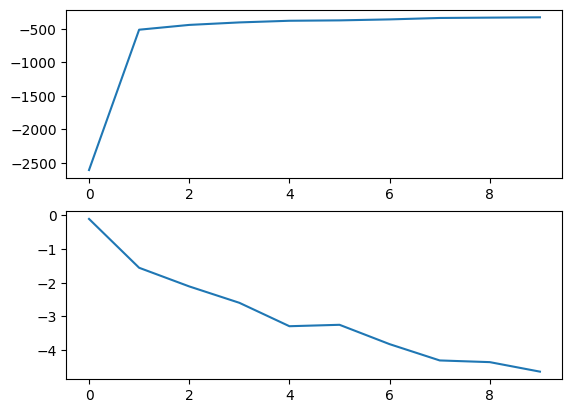

In [238]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].plot(losses_primal)
#axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
plt.show()

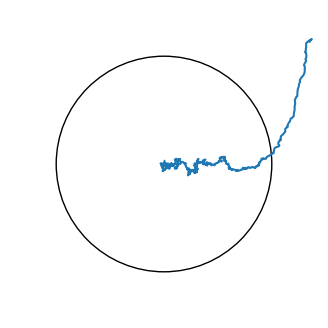

In [246]:
T = 500
states, actions = sampler.sample_trajectory(K, T)
fix, ax = plt.subplots(figsize=[4, 4])

circle = plt.Circle( (0, 0 ), 7 , fill = False )

ax.set_aspect( 1 )
ax.add_artist( circle )

plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axis('off')
plt.show()

In [24]:
epochs = 1_000
n_pe = 100
n_rho = 10_000
n_roll = 500

gamma = 0.99
eta = 0.001

b = - 10

env = RobotWorld()
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampledVariance(env, eta, tau, gamma, b, alpha, G, R)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

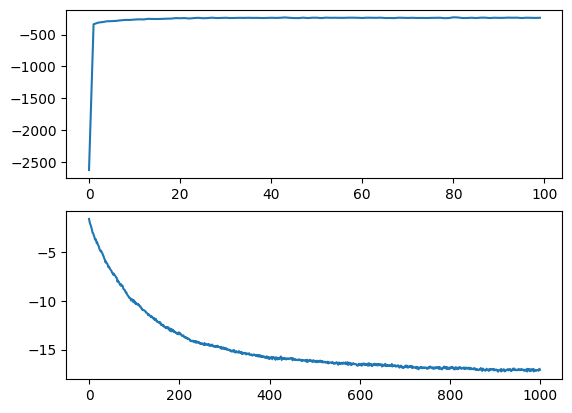

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].plot(losses_primal)
#axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
plt.show()

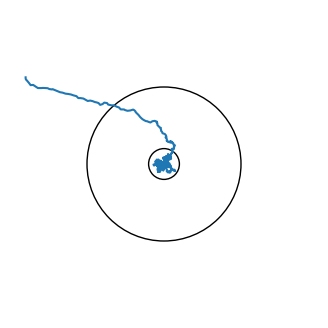

In [23]:
T = 500
states, actions = sampler.sample_trajectory(K, T)
fix, ax = plt.subplots(figsize=[4, 4])

circle_1 = plt.Circle( (0, 0 ), 5 , fill = False )
circle_2 = plt.Circle( (0, 0 ), 1 , fill = False )

ax.set_aspect( 1 )
ax.add_artist(circle_1)
ax.add_artist(circle_2)

plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axis('off')
plt.show()